# Converting netCDF images to timeseries format

For many analyses and for validation of data record, it is necessary to access time series of data for a given location. Unfortunately, satellite or model data is often supplied as "images", i.e. slices along the spatial dimension for a single time.

`qa4sm_preprocessing.nc_image_reader` provides utilities to reformat directories of image netCDF files or single netCDF files consisting of a stack of images to formats more suitable for timeseries access, e.g. the `pynetcf` timeseries format or transposed netCDF files with time as last dimension.

As an example, consider the following model output files:

In [1]:
%ls ../../tests/test-data/lis_noahmp/*

../../tests/test-data/lis_noahmp/201703:
LIS_HIST_201703300000.d01.nc*  LIS_HIST_201703310000.d01.nc*  LIS_RST_NOAH*

../../tests/test-data/lis_noahmp/201704:
LIS_HIST_201704010000.d01.nc*  LIS_HIST_201704030000.d01.nc*  LIS_RST_NOAH*
LIS_HIST_201704020000.d01.nc*  LIS_HIST_201704040000.d01.nc*


The relevant files are in nested directories, and have filenames that contain the timestamp. We can open one such file to see what's inside:

In [2]:
import xarray as xr
xr.open_dataset("../../tests/test-data/lis_noahmp/201703/LIS_HIST_201703300000.d01.nc")

<xarray.Dataset>
Dimensions:                 (north_south: 168, east_west: 207, time: 1, SnowIce_profiles: 3, SoilMoist_profiles: 4, SoilTemp_profiles: 4, SmLiqFrac_profiles: 4, SnowTProf_profiles: 3, SnowLiq_profiles: 3)
Coordinates:
  * time                    (time) datetime64[ns] 2017-03-30
Dimensions without coordinates: north_south, east_west, SnowIce_profiles, SoilMoist_profiles, SoilTemp_profiles, SmLiqFrac_profiles, SnowTProf_profiles, SnowLiq_profiles
Data variables: (12/75)
    lat                     (north_south, east_west) float32 ...
    lon                     (north_south, east_west) float32 ...
    Swnet_tavg              (north_south, east_west) float32 ...
    Lwnet_tavg              (north_south, east_west) float32 ...
    Qle_tavg                (north_south, east_west) float32 ...
    Qh_tavg                 (north_south, east_west) float32 ...
    ...                      ...
    QhCano_tavg             (north_south, east_west) float32 ...
    EvapBare_tavg           (north_south, east_west) float32 ...
    EvapHGrnd_tavg          (north_south, east_west) float32 ...
    GrndHBare_tavg          (north_south, east_west) float32 ...
    GrndHVeg_tavg           (north_south, east_west) float32 ...
    ChLeaf_tavg             (north_south, east_west) float32 ...
Attributes: (12/15)
    missing_value:           -9999.0
    NUM_SOIL_LAYERS:         4
    SOIL_LAYER_THICKNESSES:  [ 10.        30.000002  60.000004 100.      ]
    title:                   LIS land surface model output
    institution:             NASA GSFC
    source:                  
    ...                      ...
    comment:                 website: http://lis.gsfc.nasa.gov/
    MAP_PROJECTION:          EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:   29.875
    SOUTH_WEST_CORNER_LON:   -11.375
    DX:                      0.25
    DY:                      0.25

As we can see, there are lots of variables and dimensions. If we are interested in surface soil moisture, the variable of interest is "SoilMoist_inst" with the level dimension "SoilMoist_profiles" = 0. Another complicating factor is that the spatial dimensions "east_west" and "north_south" are not directly linked to latitude and longitude values.
However, the metadata contain the fields "SOUTH_WEST_CORNER_LAT", "SOUTH_WEST_CORNER_LON", "DX", and "DY", from which we can reconstruct the latitude and longitude values.

All of this can be done with the `DirectoryImageReader`.

### DirectoryImageReader

In [4]:
from qa4sm_preprocessing.nc_image_reader.readers import DirectoryImageReader

reader = DirectoryImageReader(
    "../../tests/test-data/lis_noahmp",    # the directory containing the files
    "SoilMoist_inst",                      # the variable of interest
    pattern="LIS_HIST_*.nc",               # pattern to match, to exclude files
    fmt="LIS_HIST_%Y%m%d%H%M.d01.nc",      # format string to deduce timestamps
    latdim="north_south",                  # latitude dimension name
    londim="east_west",                    # longitude dimension name
    level={"SoilMoist_profiles": 0},       # selection of level of interest
    lat=(29.875, 0.25),                    # specification of latitude vector, (start, step)
    lon=(-11.375, 0.25)                    # specification of longitude vector
)

With this reader we can either read `pygeobase` images, or images as `xr.Dataset`. The latter allows for easy plotting of images.

In [5]:
reader.read("2017-03-30")

In [10]:
reader.read_block("2017-03-30", "2017-03-30")

<xarray.Dataset>
Dimensions:         (time: 1, lat: 168, lon: 207)
Coordinates:
  * time            (time) datetime64[ns] 2017-03-30
  * lat             (lat) float64 29.88 30.12 30.38 30.62 ... 71.12 71.38 71.62
  * lon             (lon) float64 -11.38 -11.12 -10.88 ... 39.62 39.88 40.12
Data variables:
    SoilMoist_inst  (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
Attributes: (12/15)
    missing_value:           -9999.0
    NUM_SOIL_LAYERS:         4
    SOIL_LAYER_THICKNESSES:  [ 10.        30.000002  60.000004 100.      ]
    title:                   LIS land surface model output
    institution:             NASA GSFC
    source:                  
    ...                      ...
    comment:                 website: http://lis.gsfc.nasa.gov/
    MAP_PROJECTION:          EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:   29.875
    SOUTH_WEST_CORNER_LON:   -11.375
    DX:                      0.25
    DY:                      0.25

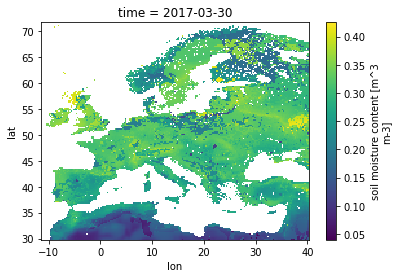

In [12]:
reader.read_block("2017-03-30", "2017-03-30")["SoilMoist_inst"].plot()

## Image to timeseries

To construct timeseries, you can pass the `DirectoryImageReader` instance to `repurpose` in your own Python code, or you can use the `repurpose_images` script. This script provides all the options that the DirectoryImageReader also provides.

In [16]:
%%bash

time repurpose_images\
    --parameter SoilMoist_inst\
    --pattern 'LIS_HIST_*.nc'\
    --time_fmt "LIS_HIST_%Y%m%d%H%M.d01.nc"\
    --latdim north_south\
    --londim east_west\
    --lat 29.875 0.25\
    --lon -11.375 0.25\
    --level "SoilMoist_profiles:0"\
    --\
    "../../tests/test-data/lis_noahmp"\
    "../../tests/test-data/lis_noahmp_timeseries"\
    "2017-03-30"\
    "2017-04-04"

Converting data from 2017-03-30 00:00:00 to 2017-04-04 00:00:00 into directory ../../tests/test-data/lis_noahmp_timeseries.


/home/sscherre/miniconda3/envs/qa4sm_preprocessing/lib/python3.9/site-packages/pyresample/bilinear/__init__.py:49: UserWarning: XArray and/or zarr not found, XArrayBilinearResampler won't be available.
  warnings.warn("XArray and/or zarr not found, XArrayBilinearResampler won't be available.")

real	0m1,996s
user	0m2,432s
sys	0m1,616s


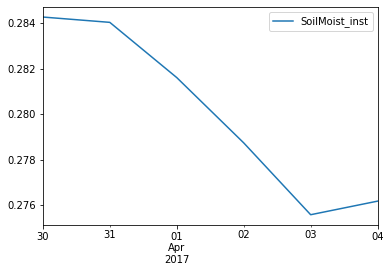

In [18]:
from qa4sm_preprocessing.nc_image_reader.readers import GriddedNcOrthoMultiTs

reader = GriddedNcOrthoMultiTs("../../tests/test-data/lis_noahmp_timeseries")
ts = reader.read(16.375, 48.125)
ts.plot();

## Alternative: Creating transposed stack

As an alternative to the `pynetcf` format, you can also just create a transposed (and chunked) netCDF optimized for timeseries access. Again, there's a script for this that has a very similar interface than `repurpose_images`:

In [19]:
%%bash

time transpose_images\
    --parameter SoilMoist_inst\
    --pattern 'LIS_HIST_*.nc'\
    --time_fmt "LIS_HIST_%Y%m%d%H%M.d01.nc"\
    --latdim north_south\
    --londim east_west\
    --lat 29.875 0.25\
    --lon -11.375 0.25\
    --level "SoilMoist_profiles:0"\
    --\
    "../../tests/test-data/lis_noahmp"\
    "../../tests/test-data/lis_noahmp_transposed.nc"\
    "2017-03-30"\
    "2017-04-04"

Converting data from 2017-03-30 00:00:00 to 2017-04-04 00:00:00 into directory ../../tests/test-data/lis_noahmp_transposed.nc.
Creating transposed file:


/home/sscherre/miniconda3/envs/qa4sm_preprocessing/lib/python3.9/site-packages/pyresample/bilinear/__init__.py:49: UserWarning: XArray and/or zarr not found, XArrayBilinearResampler won't be available.
  warnings.warn("XArray and/or zarr not found, XArrayBilinearResampler won't be available.")
100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

real	0m1,437s
user	0m1,823s
sys	0m1,781s


In [21]:
xr.open_dataset("../../tests/test-data/lis_noahmp_transposed.nc")["SoilMoist_inst"]

<xarray.DataArray 'SoilMoist_inst' (lat: 168, lon: 207, time: 6)>
[208656 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 29.88 30.12 30.38 30.62 ... 70.88 71.12 71.38 71.62
  * lon      (lon) float64 -11.38 -11.12 -10.88 -10.62 ... 39.62 39.88 40.12
  * time     (time) datetime64[ns] 2017-03-30 2017-03-31 ... 2017-04-04
Attributes:
    units:          m^3 m-3
    standard_name:  soil_moisture_content
    long_name:      soil moisture content
    vmin:           -1000000000000000.0
    vmax:           1000000000000000.0

This can be easily accessed with `xarray`. We see that the time dimension is now the last dimension.

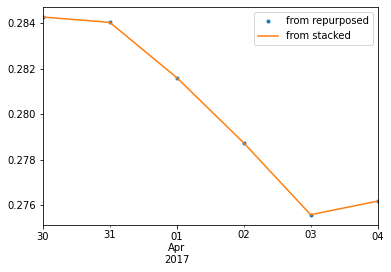

In [23]:
from qa4sm_preprocessing.nc_image_reader.readers import XarrayTSReader
import matplotlib.pyplot as plt

stacked_reader = XarrayTSReader("../../tests/test-data/lis_noahmp_transposed.nc", "SoilMoist_inst")
ts_from_stacked = reader.read(16.375, 48.125)["SoilMoist_inst"]
ts["SoilMoist_inst"].plot(marker=".", ls="", label="from repurposed")
ax = plt.gca()
ts_from_stacked.plot(ax=ax, label="from stacked")
plt.legend();

## Performance comparison

Tests with a random dataset of ~57GB size gave the following results for the comparison between repurposing and transposing:

Pre-processing:
- repurpose: ~40 min
- transpose: ~40 min

Timeseries access (mean for 700 timeseries):
- repurposed: ~6s
- transposed: ~2.5s